In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import yaml

torch.set_float32_matmul_precision("medium")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Create Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


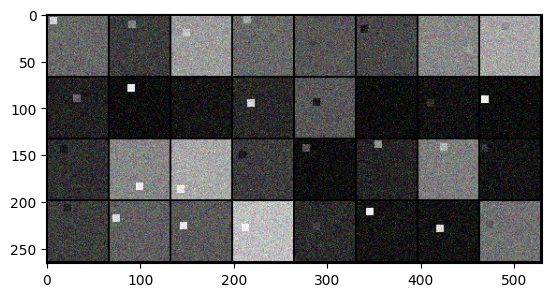

In [2]:
from pytorch_lightning import LightningDataModule
import torch
from torchvision.datasets import VisionDataset
from torchvision import transforms
import os
from PIL import Image


class SquaresDataset(VisionDataset):
    def __len__(self):
        return len(os.listdir(self.root))

    def __getitem__(self, idx):
        files = os.listdir(self.root)
        img = Image.open(os.path.join(self.root, files[idx]))

        if self.transform:
            img = self.transform(img)

        noise = torch.randn_like(img) * 0.1
        return img + noise, -1


class SquaresLT(LightningDataModule):

    def __init__(self, root, batch_size=32):
        super().__init__()
        self.root = root
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.dataset = SquaresDataset(
            root=self.root,
            transform=transforms.Compose(
                [
                    transforms.ToTensor(),
                ]
            ),
        )
        train_size = int(0.8 * len(self.dataset))
        test_size = len(self.dataset) - train_size
        self.train_dataset, self.test_dataset = torch.utils.data.random_split(
            self.dataset, [train_size, test_size]
        )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset, batch_size=self.batch_size, num_workers=4, shuffle=True
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset, batch_size=self.batch_size, num_workers=4
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset, batch_size=self.batch_size, num_workers=4
        )


squares_dataset = SquaresLT(
    root="/home/ducha/Workspace/Data/peal/square_nonoise/imgs",
)
squares_dataset.setup()

sample_imgs = next(iter(squares_dataset.train_dataloader()))[0]

plt.imshow(make_grid(sample_imgs, nrow=8).permute(1, 2, 0).cpu().detach().numpy())

# Load VAE model

In [3]:
from pytorch_lightning.loggers import TensorBoardLogger
from models import *
from experiment import VAEXperiment
import shutil

config_path = "configs/square_vq_vae.yaml"
with open(config_path, "r") as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

print(config)

tag = "_dyn_noise"
config_tagged = config_path.split("/")[-1].replace(".yaml", f"{tag}.yaml")
print(config_tagged)


tb_logger = TensorBoardLogger(
    save_dir=config["logging_params"]["save_dir"],
    name=config["logging_params"]["name"] + tag,
)

log_path = tb_logger.log_dir
print(log_path)
os.makedirs(log_path, exist_ok=True)
shutil.copy(config_path, log_path + "/" + config_tagged)

# For reproducibility
# seed_everything(config["exp_params"]["manual_seed"], True)

model = vae_models[config["model_params"]["name"]](**config["model_params"])
experiment = VAEXperiment(model, config["exp_params"])

{'model_params': {'name': 'VQVAE', 'in_channels': 3, 'embedding_dim': 128, 'num_embeddings': 512, 'img_size': 64, 'beta': 0.25}, 'exp_params': {'LR': 0.0001, 'weight_decay': 0.0, 'scheduler_gamma': 0.995, 'kld_weight': 0.00025, 'manual_seed': 1265}, 'trainer_params': {'accelerator': 'gpu', 'devices': 1, 'max_epochs': 100, 'check_val_every_n_epoch': 5}, 'logging_params': {'save_dir': 'logs/', 'name': 'VQVAE_square'}}
square_vq_vae_dyn_noise.yaml


Missing logger folder: logs/VQVAE_square_dyn_noise


logs/VQVAE_square_dyn_noise/version_0


In [4]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# from pytorch_lightning.plugins import DDPPlugin
from pathlib import Path
import os

runner = Trainer(
    logger=tb_logger,
    callbacks=[
        LearningRateMonitor(),
        ModelCheckpoint(
            save_top_k=2,
            dirpath=os.path.join(tb_logger.log_dir, "checkpoints"),
            monitor="val_Reconstruction_Loss",
            save_last=True,
        ),
    ],
    log_every_n_steps=1,
    # strategy=DDPPlugin(find_unused_parameters=False),
    **config["trainer_params"],
)


Path(f"{tb_logger.log_dir}/Samples").mkdir(exist_ok=True, parents=True)
Path(f"{tb_logger.log_dir}/Reconstructions").mkdir(exist_ok=True, parents=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
print(f"======= Training {config['model_params']['name']} =======")
runner.fit(
    experiment, datamodule=SquaresLT(root="/home/ducha/Workspace/Data/peal/square/imgs")
)

======= Training VQVAE =======


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | VQVAE | 9.9 M 
--------------------------------
9.9 M     Trainable params
0         Non-trainable params
9.9 M     Total params
39.638    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
